# **Path**

In [2]:
path='/kaggle/input'

# **Importing Libraries**

In [3]:
import os as osx

import random as randomx

#import Torch
import torch as trc
import torch.nn as nnx
import torch.optim as optimx
from torchvision import datasets as dtst, models as mdl, transforms as trnsfrm
from torch.optim.lr_scheduler import ReduceLROnPlateau as rlrp
import torchvision.transforms.functional as F
from torch.utils.data import random_split as randomx_split, DataLoader as dtldr
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as asx, f1_score as f1x, recall_score as rsx , precision_score as psx, confusion_matrix as cmx, roc_auc_score as rasx, roc_curve as rcx
from sklearn.metrics import classification_report as crx
import matplotlib.pyplot as pltx
import numpy as npx
import seaborn as snsx
import pandas as pdx
from PIL import Image as img

import cv2
import timm

Check Availability of Cuda

In [4]:
dvc = trc.device("cuda" if trc.cuda.is_available() else "cpu") # dvc denotes device
print("Using device:", dvc)

Using device: cuda


# **Spliting Data in Brain Tumor and Healthy**

In [5]:
yes_dir = osx.path.join(path, 'Brain Tumor Data Set', 'Brain Tumor Data Set','Brain Tumor')
no_dir = osx.path.join(path, 'Brain Tumor Data Set', 'Brain Tumor Data Set','Healthy')

# List all files
yes_files = [osx.path.join(yes_dir, f) for f in osx.listdir(yes_dir) if osx.path.isfile(osx.path.join(yes_dir, f))]
no_files = [osx.path.join(no_dir, f) for f in osx.listdir(no_dir) if osx.path.isfile(osx.path.join(no_dir, f))]

# Select a subset of files
num_files_to_select = 1500


selected_yes_files = randomx.sample(yes_files, min(num_files_to_select, len(yes_files)))
selected_no_files = randomx.sample(no_files, min(num_files_to_select, len(no_files)))
selected_files=selected_yes_files+selected_no_files
print(f"Selected {len(selected_yes_files)} 'yes' files")
print(f"Selected {len(selected_no_files)} 'no' files")

Selected 1500 'yes' files
Selected 1500 'no' files


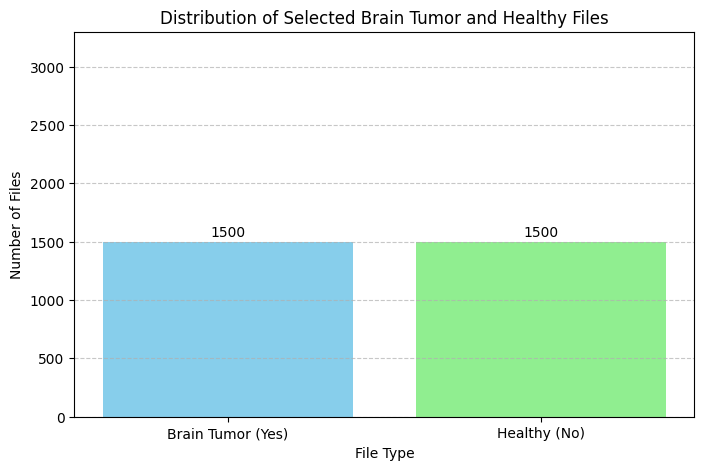

In [6]:
file_types = ['Brain Tumor (Yes)', 'Healthy (No)']
counts = [len(selected_yes_files), len(selected_no_files)]

pltx.figure(figsize=(8, 5))
pltx.bar(file_types, counts, color=['skyblue', 'lightgreen'])
pltx.title("Distribution of Selected Brain Tumor and Healthy Files")
pltx.xlabel("File Type")
pltx.ylabel("Number of Files")
pltx.ylim(0,  len(selected_files)* 1.1) # Set y-axis limit slightly above max count
pltx.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on the bars
for i, count in enumerate(counts):
    pltx.text(i, count + 20, str(count), ha='center', va='bottom')

pltx.show()

# **Visualization**

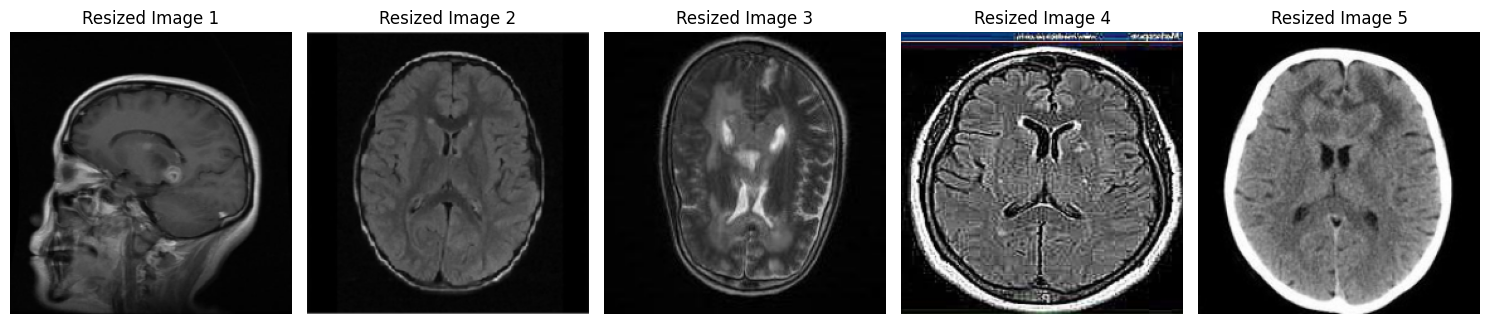

In [7]:
# Define the image transformation (resizing)
data_transform = trnsfrm.Compose([
    trnsfrm.Resize((224, 224)),
    trnsfrm.ToTensor(),
])

# Load a few images and apply the transformation
num_images_to_visualize = 5
sample_files = randomx.sample(selected_files, num_images_to_visualize)

pltx.figure(figsize=(15, 5))
for i, file_path in enumerate(sample_files):
    image = img.open(file_path).convert('RGB')
    transformed_image = data_transform(image)

    # Convert the tensor back to a PIL Image for displaying
    transformed_image_display = trnsfrm.ToPILImage()(transformed_image)

    pltx.subplot(1, num_images_to_visualize, i + 1)
    pltx.imshow(transformed_image_display)
    pltx.title(f"Resized Image {i+1}")
    pltx.axis('off')
pltx.tight_layout()
pltx.show()

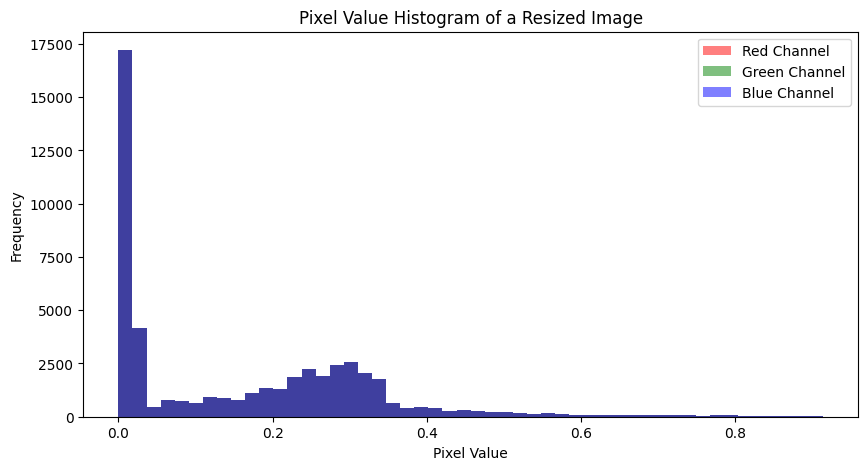

In [8]:
# Visualize a single image as a histogram of pixel values
if sample_files:
    image = img.open(sample_files[0]).convert('RGB')
    transformed_image = data_transform(image)

    # Convert tensor to numpy array for histogram
    img_np = transformed_image.numpy()

    pltx.figure(figsize=(10, 5))

    # Plot histogram for each channel (R, G, B)
    colors = ['red', 'green', 'blue']
    for channel, color in enumerate(colors):
        pltx.hist(img_np[channel].flatten(), bins=50, color=color, alpha=0.5, label=f'{color.capitalize()} Channel')

    pltx.title("Pixel Value Histogram of a Resized Image")
    pltx.xlabel("Pixel Value")
    pltx.ylabel("Frequency")
    pltx.legend()
    pltx.show()

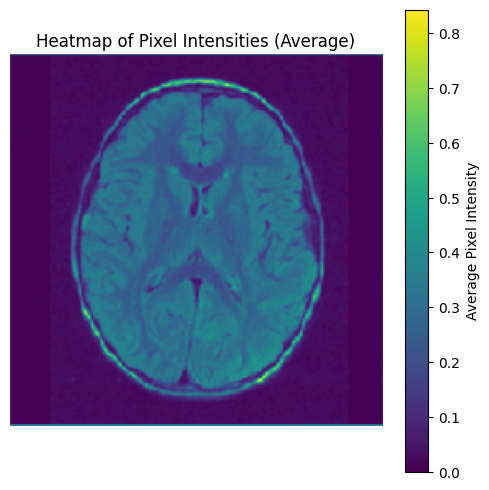

In [9]:
# Visualize a heatmap of pixel values
if sample_files:
    image = img.open(sample_files[1]).convert('RGB')
    transformed_image = data_transform(image)

    # Calculate the average across color channels for a grayscale heatmap
    avg_image = trc.mean(transformed_image, dim=0)

    pltx.figure(figsize=(6, 6))
    pltx.imshow(avg_image.numpy(), cmap='viridis') # Use a colormap like 'viridis' or 'plasma'
    pltx.title("Heatmap of Pixel Intensities (Average)")
    pltx.colorbar(label='Average Pixel Intensity')
    pltx.axis('off')
    pltx.show()

# **Train, Validate and Test Dataframe splits**

In [10]:
# Split the data into train, validation, and test sets
trn_df, tst_df = tts(selected_files, train_size = 0.95, random_state = 0)
trn_df,val_df = tts(trn_df, train_size=0.9,random_state = 0)


print(f"\nNumber of samples in training set: {len(trn_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(tst_df)}")

# Calculate percentages
total_samples = len(selected_files)
trn_prcnt = (len(trn_df) / total_samples) * 100
val_prcnt = (len(val_df) / total_samples) * 100
tst_prcnt = (len(tst_df) / total_samples) * 100

print(f"\nNumber of samples in training set: {len(trn_df)} ({trn_prcnt:.2f}%)")
print(f"Number of samples in validation set: {len(val_df)} ({val_prcnt:.2f}%)")
print(f"Number of samples in test set: {len(tst_df)} ({tst_prcnt:.2f}%)")


Number of samples in training set: 2565
Number of samples in validation set: 285
Number of samples in test set: 150

Number of samples in training set: 2565 (85.50%)
Number of samples in validation set: 285 (9.50%)
Number of samples in test set: 150 (5.00%)


Distribution of classes in Train, Validate and Test Sets

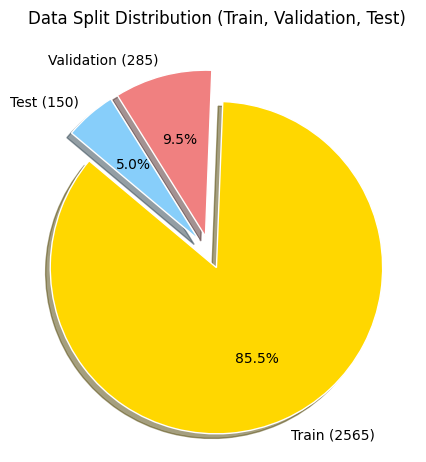

In [11]:
# Add a pie chart showing the percentage distribution of the splits (train, validation, test)
split_sizes = [len(trn_df), len(val_df), len(tst_df)]
split_labels = [f'Train ({len(trn_df)})', f'Validation ({len(val_df)})', f'Test ({len(tst_df)})']
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0.1, 0.1)

fig_shifted = pltx.figure(figsize=(10, 10))
ax_shifted = fig_shifted.add_axes([0.4, 0.3, 0.4, 0.4])

ax_shifted.pie(split_sizes, explode=explode, labels=split_labels, colors=colors, autopct='%1.1f%%',
               shadow=True, startangle=140, wedgeprops={'edgecolor': 'white'})
ax_shifted.axis('equal')
ax_shifted.set_title("Data Split Distribution (Train, Validation, Test)", y=1.05) # Adjust title position

pltx.show()


In [12]:
# Function to count 'yes' and 'no' files in a list of file paths
def count_yes_no(file_list, yes_dir, no_dir):
  yes_count = 0
  no_count = 0
  for file_path in file_list:
    if file_path.startswith(yes_dir):
      yes_count += 1
    elif file_path.startswith(no_dir):
      no_count += 1
  return yes_count, no_count

# Count for training set
trn_yes_count, trn_no_count = count_yes_no(trn_df, yes_dir, no_dir)
print(f"\nTraining Set: Yes = {trn_yes_count}, No = {trn_no_count}")

# Count for validation set
val_yes_count, val_no_count = count_yes_no(val_df, yes_dir, no_dir)
print(f"Validation Set: Yes = {val_yes_count}, No = {val_no_count}")

# Count for test set
tst_yes_count, tst_no_count = count_yes_no(tst_df, yes_dir, no_dir)
print(f"Test Set: Yes = {tst_yes_count}, No = {tst_no_count}")



Training Set: Yes = 1289, No = 1276
Validation Set: Yes = 130, No = 155
Test Set: Yes = 81, No = 69


# **Transforming the data**

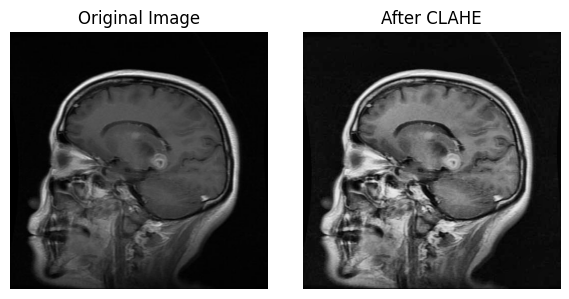

In [13]:
class ApplyCLAHE:
    def __init__(self, clipLimit=2.0, tileGridSize=(8,8)):
        self.clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)

    def __call__(self, img_pil): # Renamed input variable to avoid shadowing
        img_np = npx.array(img_pil)
        if len(img_np.shape) == 3 and img_np.shape[2] == 3:
            clahe_img_np = npx.zeros_like(img_np)
            for i in range(img_np.shape[-1]):
                clahe_img_np[:, :, i] = self.clahe.apply(img_np[:, :, i])
        elif len(img_np.shape) == 2:
            clahe_img_np = self.clahe.apply(img_np)
        else:
            print("Unsupported image format for CLAHE. Returning original.")
            return img_pil # Return the original PIL Image object
        # Corrected line: Use the imported alias 'img' instead of 'Image'
        return img.fromarray(clahe_img_np)

# Sample image visualization
if sample_files:
    sample_image_path = sample_files[0]
    original_image = img.open(sample_image_path).convert('RGB')
    clahe_transform = ApplyCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_applied_image = clahe_transform(original_image)

    # Display side-by-side
    pltx.figure(figsize=(6, 3))
    pltx.subplot(1, 2, 1)
    pltx.imshow(original_image)
    pltx.title("Original Image")
    pltx.axis('off')

    pltx.subplot(1, 2, 2)
    pltx.imshow(clahe_applied_image)
    pltx.title("After CLAHE")
    pltx.axis('off')
    pltx.tight_layout()
    pltx.show()

Applying it for all images

## Creating Data Loader

In [14]:
class Tumordtst(trc.utils.data.Dataset): # Corrected from dtst to Dataset
    def __init__(self, file_list, yes_dir, transform=None):
        self.file_list = file_list
        self.yes_dir = yes_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = img.open(img_path).convert('RGB') # Ensure RGB
        label = 1 if img_path.startswith(self.yes_dir) else 0

        if self.transform:
            image = self.transform(image)

        return image, label

data_transform_with_clahe = trnsfrm.Compose([
    ApplyCLAHE(clipLimit=2.0, tileGridSize=(8,8)),
    trnsfrm.Resize((224, 224)),
    trnsfrm.ToTensor(),
    trnsfrm.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])
])
trn_dtst = Tumordtst(trn_df, yes_dir, transform=data_transform_with_clahe)
trn_ldr = dtldr(trn_dtst, batch_size=32, shuffle=True)

# **Base Class for trning and tsting**

In [15]:
class Tumordtst(trc.utils.data.Dataset):
    def __init__(self, file_list, yes_dir, transform=None):
        self.file_list = file_list
        self.yes_dir = yes_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = img.open(img_path).convert('RGB') # Ensure RGB
        label = 1 if img_path.startswith(self.yes_dir) else 0

        if self.transform:
            image = self.transform(image)

        return image, label

trn_dtst = Tumordtst(trn_df, yes_dir, transform=data_transform_with_clahe)
val_dtst = Tumordtst(val_df, yes_dir, transform=data_transform_with_clahe)
tst_dtst = Tumordtst(tst_df, yes_dir, transform=data_transform_with_clahe)

trn_ldr = dtldr(trn_dtst, batch_size=32, shuffle=True, num_workers=2)
val_ldr = dtldr(val_dtst, batch_size=32, shuffle=False, num_workers=2)
tst_ldr = dtldr(tst_dtst, batch_size=32, shuffle=False, num_workers=2)

In [16]:
class Basetrner:
    def __init__(self, model, trn_loader, val_loader, tst_loader,
                 criterion, optimizer, scheduler=None, device='cuda',
                 early_stopping_patience=5, model_name='best_model.pt'):
        self.model = model.to(device)
        self.trn_loader = trn_loader
        self.val_loader = val_loader
        self.tst_loader = tst_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.early_stopping_patience = early_stopping_patience
        self.model_name = model_name

        # History
        self.trn_losses, self.val_losses = [], []
        self.trn_accuracies, self.val_accuracies = [], []

    def trn(self, num_epochs):
        best_val_loss = npx.inf
        patience_counter = 0

        for epoch in range(num_epochs):
            self.model.train()
            trn_loss, trn_preds, trn_targets = 0.0, [], []
            for inputs, labels in self.trn_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                trn_loss += loss.item()
                preds = trc.argmax(outputs, dim=1)
                trn_preds.extend(preds.cpu().numpy())
                trn_targets.extend(labels.cpu().numpy())

            epoch_trn_loss = trn_loss / len(self.trn_loader)
            epoch_trn_acc = asx(trn_targets, trn_preds)
            self.trn_losses.append(epoch_trn_loss)
            self.trn_accuracies.append(epoch_trn_acc)

            # Validation
            #val_loss, val_acc = self.evaluate(self.val_loader)
            res=self.evaluate(self.val_loader)
            val_loss=res['lss_avg']
            val_acc=res['acc']
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"train Loss: {epoch_trn_loss:.4f} Acc: {epoch_trn_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.scheduler:
                self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                trc.save(self.model.state_dict(), self.model_name)
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print("Early stopping triggered.")
                    break

        self.plot_accuracy_loss()
    def evaluate(self, loader):
        self.model.eval()
        loss_total, preds_all, labels_all = 0.0, [], []
    
        with trc.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
    
                loss_total += loss.item()
                preds = trc.argmax(outputs, dim=1)
                preds_all.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())
    
        loss_avg = loss_total / len(loader)
        acc = asx(labels_all, preds_all)
        precision = psx(labels_all, preds_all, average='macro')
        recall = rsx(labels_all, preds_all, average='macro')
        f1 = f1x(labels_all, preds_all, average='macro')
        res={
            "lss_avg":loss_avg,
            "acc":acc,
            "prec": precision,
            "fone":f1,
            "recall":recall
        }
        return res
    def save_model(self, path=None):
        """Save the current model state dict."""
        if path is None:
            path = self.model_name
        trc.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path=None):
        """Load the model state dict from file."""
        if path is None:
            path = self.model_name
        self.model.load_state_dict(trc.load(path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        print(f"Model loaded from {path}")

    def print_metrics(self, ldr):
        self.model.eval()
        y_hat, y_org, y_prob = [], [], []
    
        with trc.no_grad():
            for xx, yy in ldr:
                xx, yy = xx.to(self.device), yy.to(self.device)
                zz = self.model(xx)
                pb = trc.softmax(zz, dim=1)
                prd = trc.argmax(pb, dim=1)
    
                y_hat.extend(prd.cpu().numpy())
                y_org.extend(yy.cpu().numpy())
                y_prob.extend(pb[:, 1].cpu().numpy())  # Probability of class 1
    
        # Evaluate summary
        res = self.evaluate(ldr)
        acc = res['acc']
        prec = res['prec']
        rec = res['recall']
        f1 = res['fone']
    
        print(f"Acc : {acc:.4f}")
        print(f"Pr  : {prec:.4f}")
        print(f"Rc  : {rec:.4f}")
        print(f"F1  : {f1:.4f}")
    
        # --- Classification Report ---
        print("\nClassification Report:")
        rpt = crx(y_org, y_hat, digits=4, target_names=['No Tumour', 'Tumour'])
        print(rpt)
    
        # --- Confusion Matrix ---
        cm = cmx(y_org, y_hat)
        pltx.figure(figsize=(5.5, 4.5))
        snsx.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                     xticklabels=['No Tumour', 'Tumour'],
                     yticklabels=['No Tumour', 'Tumour'])
        pltx.title("C-Matrix")
        pltx.xlabel("Pred")
        pltx.ylabel("True")
        pltx.tight_layout()
        pltx.show()
    
        # --- ROC-AUC Curve ---
        fpr, tpr, _ = rcx(y_org, y_prob)
        auc_val = rasx(y_org, y_prob)
    
        pltx.figure()
        pltx.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}", color='darkorange')
        pltx.plot([0, 1], [0, 1], linestyle='--', color='gray')
        pltx.title("ROC-AUC")
        pltx.xlabel("FPR")
        pltx.ylabel("TPR")
        pltx.grid(True)
        pltx.legend(loc='lower right')
        pltx.tight_layout()
        pltx.show()
    
        return {"A": acc, "P": prec, "R": rec, "F": f1, "AUC": auc_val}

   
    def plot_accuracy_loss(self):
        pltx.figure(figsize=(10, 4))
        pltx.subplot(1, 2, 1)
        pltx.plot(self.trn_losses, label='Train Loss')
        pltx.plot(self.val_losses, label='Val Loss')
        pltx.legend()
        pltx.title("Loss over Epochs")
        pltx.xlabel("Epoch")
        pltx.ylabel("Loss")

        pltx.subplot(1, 2, 2)
        pltx.plot(self.trn_accuracies, label='Train Accuracy')
        pltx.plot(self.val_accuracies, label='Val Accuracy')
        pltx.legend()
        pltx.title("Accuracy over Epochs")
        pltx.xlabel("Epoch")
        pltx.ylabel("Accuracy")

        pltx.tight_layout()
        pltx.show()


    
    def predict_random_from_loader(self, dataloader, num_images=5):
        """Randomly select N images from the dataloader, predict, and display all in one row."""
    
        self.model.eval()
    
        # Flatten dataset from the dataloader
        all_images, all_labels = [], []
        for images, labels in dataloader:
            for i in range(images.size(0)):
                all_images.append(images[i])
                all_labels.append(labels[i])
    
        total_samples = len(all_images)
        chosen_indices = randomx.sample(range(total_samples), min(num_images, total_samples))
    
        # Prepare figure
        fig, axs = pltx.subplots(1, num_images, figsize=(num_images * 3, 3))  # smaller images
    
        for ax, idx in zip(axs, chosen_indices):
            image_tensor = all_images[idx].unsqueeze(0).to(self.device)
            true_label = all_labels[idx].item()
    
            with trc.no_grad():
                output = self.model(image_tensor)
                probs = trc.softmax(output, dim=1)
                pred = trc.argmax(probs, dim=1).item()
                confidence = probs[0][pred].item()
    
            pred_label = "Brain Tumour" if pred == 1 else "No Tumour"
            actual_label = "Brain Tumour" if true_label == 1 else "No Tumour"
    
            # De-normalize image
            image_to_show = all_images[idx].clone()
            for c in range(3):
                image_to_show[c] = image_to_show[c] * 0.5 + 0.5
            image_to_show = image_to_show.clamp(0, 1)
    
            # Display
            ax.imshow(F.to_pil_image(image_to_show.cpu()))
            ax.set_title(f"P: {pred_label}\nA: {actual_label}", fontsize=8)
            ax.axis('off')
    
        pltx.tight_layout()
        pltx.show()


# **Hybrid: Resnet18 & DenseNet121**

In [17]:
class resnetDenseNet(nnx.Module):
    def __init__(self, num_classes=2):
        super(resnetDenseNet, self).__init__()
        self.resnet = timm.create_model('resnet18', pretrained=True, num_classes=0, global_pool='')
        self.densenet = timm.create_model('densenet121', pretrained=True, num_classes=0, global_pool='')

        # Get feature sizes
        self.resnet_out = self.resnet.num_features
        self.densenet_out = self.densenet.num_features
        total_features = self.resnet_out + self.densenet_out
        self.global_pool = nnx.AdaptiveAvgPool2d(1)

        # Classifier with BatchNorm and Dropout
        self.classifier = nnx.Sequential(
            nnx.Flatten(),
            nnx.Linear(total_features, 256),
            nnx.BatchNorm1d(256),  # BatchNorm for stabilization
            nnx.ReLU(),
            nnx.Dropout(0.6),  # Increased dropout
            nnx.Linear(256, 128),
            nnx.BatchNorm1d(128),  # BatchNorm for stabilization
            nnx.ReLU(),
            nnx.Dropout(0.5),
            nnx.Linear(128, num_classes)
        )

    def forward(self, x):
        r = self.global_pool(self.resnet(x))  # [B, resnet_out, 1, 1]
        d = self.global_pool(self.densenet(x))  # [B, densenet_out, 1, 1]
        concat = trc.cat([r, d], dim=1)  # [B, total_features, 1, 1]
        return self.classifier(concat)

In [18]:
# Define the ResNet-DenseNet Hybrid Model
resDensenet_model = resnetDenseNet(num_classes=2)

# Define loss function with label smoothing for stabilization
criterion = nnx.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing helps stabilize loss

# Define optimizer with weight decay for regularization
optimizer = optimx.Adam(
    resDensenet_model.parameters(),
    lr=0.0005,  # Lower learning rate for finer updates
    weight_decay=1e-4  # Add weight decay to reduce overfitting
)

# Learning rate scheduler with patience
scheduler = rlrp(optimizer, mode='min', factor=0.1, patience=3)

# Initialize the trainer with an increased patience for early stopping
resDensenet_trner = Basetrner(
    model=resDensenet_model,
    trn_loader=trn_ldr,
    val_loader=val_ldr,
    tst_loader=tst_ldr,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=dvc,
    early_stopping_patience=10,  # Increased patience for smoother convergence
    model_name='ResNet_Dense_Hybrid.pt'
)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Epoch [1/20] train Loss: 0.4118 Acc: 0.8612 | Val Loss: 0.2612 Acc: 0.9754
Epoch [2/20] train Loss: 0.2592 Acc: 0.9774 | Val Loss: 0.2345 Acc: 0.9895
Epoch [3/20] train Loss: 0.2387 Acc: 0.9914 | Val Loss: 0.2497 Acc: 0.9719
Epoch [4/20] train Loss: 0.2615 Acc: 0.9758 | Val Loss: 0.2391 Acc: 0.9825
Epoch [5/20] train Loss: 0.2312 Acc: 0.9910 | Val Loss: 0.2233 Acc: 0.9895
Epoch [6/20] train Loss: 0.2459 Acc: 0.9786 | Val Loss: 0.2112 Acc: 0.9930
Epoch [7/20] train Loss: 0.2415 Acc: 0.9899 | Val Loss: 0.2128 Acc: 0.9930
Epoch [8/20] train Loss: 0.2438 Acc: 0.9883 | Val Loss: 0.2111 Acc: 0.9930
Epoch [9/20] train Loss: 0.2168 Acc: 0.9973 | Val Loss: 0.2158 Acc: 0.9895
Epoch [10/20] train Loss: 0.2176 Acc: 0.9949 | Val Loss: 0.2293 Acc: 0.9825
Epoch [11/20] train Loss: 0.2248 Acc: 0.9918 | Val Loss: 0.2117 Acc: 0.9930
Epoch [12/20] train Loss: 0.2447 Acc: 0.9809 | Val Loss: 0.2656 Acc: 0.9649
Epoch [13/20] train Loss: 0.2406 Acc: 0.9813 | Val Loss: 0.2088 Acc: 0.9965
Epoch [14/20] train L

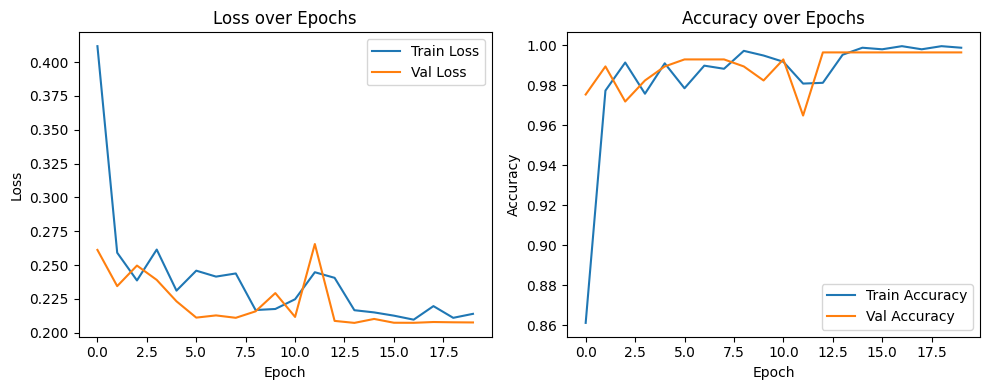

Model saved to /kaggle/working/ResNet_Dense_Hybrid.pth


In [19]:
# Train the Hybrid model
num_epochs = 20 # You can adjust this number
resDensenet_trner.trn(num_epochs)
resDensenet_trner.save_model('/kaggle/working/ResNet_Dense_Hybrid.pth')

Acc : 1.0000
Pr  : 1.0000
Rc  : 1.0000
F1  : 1.0000

Classification Report:
              precision    recall  f1-score   support

   No Tumour     1.0000    1.0000    1.0000      1276
      Tumour     1.0000    1.0000    1.0000      1289

    accuracy                         1.0000      2565
   macro avg     1.0000    1.0000    1.0000      2565
weighted avg     1.0000    1.0000    1.0000      2565



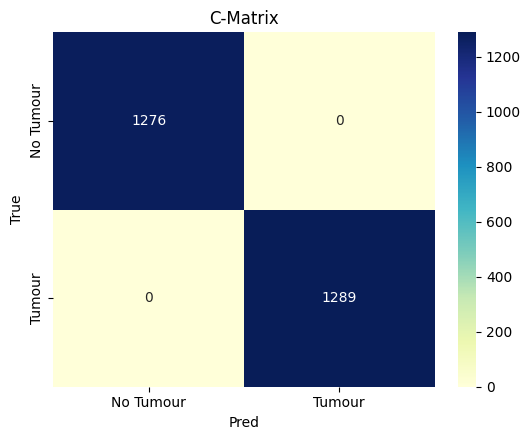

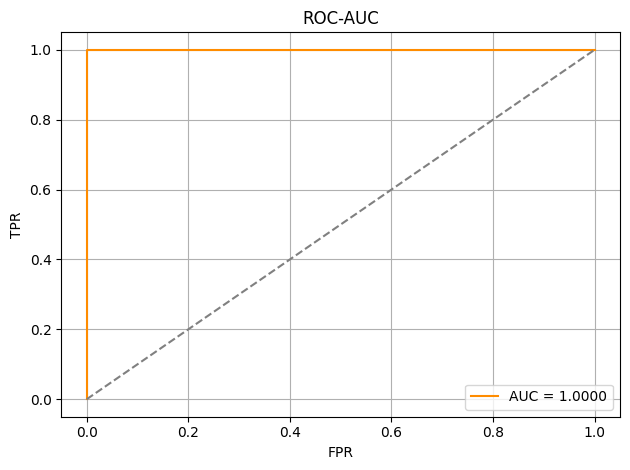

In [20]:
ResNet_DenseNet_Train_Result=resDensenet_trner.print_metrics(trn_ldr)

Acc : 0.9867
Pr  : 0.9859
Rc  : 0.9877
F1  : 0.9866

Classification Report:
              precision    recall  f1-score   support

   No Tumour     0.9718    1.0000    0.9857        69
      Tumour     1.0000    0.9753    0.9875        81

    accuracy                         0.9867       150
   macro avg     0.9859    0.9877    0.9866       150
weighted avg     0.9870    0.9867    0.9867       150



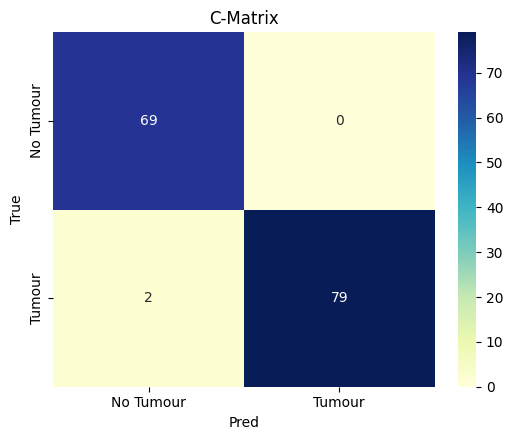

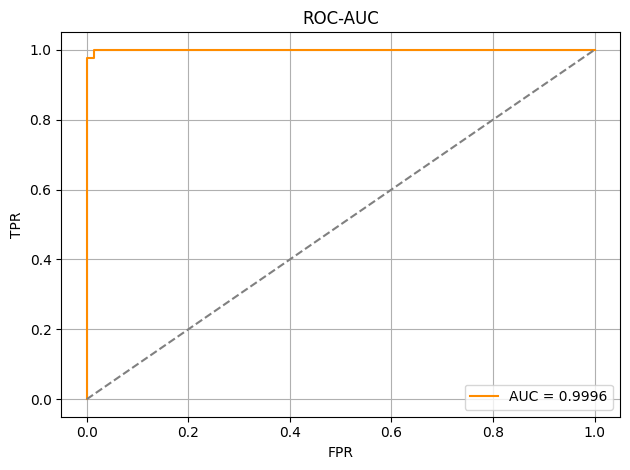

In [21]:
ResNet_DenseNet_Test_Result=resDensenet_trner.print_metrics(tst_ldr)

Model loaded from ResNet_Dense_Hybrid.pt


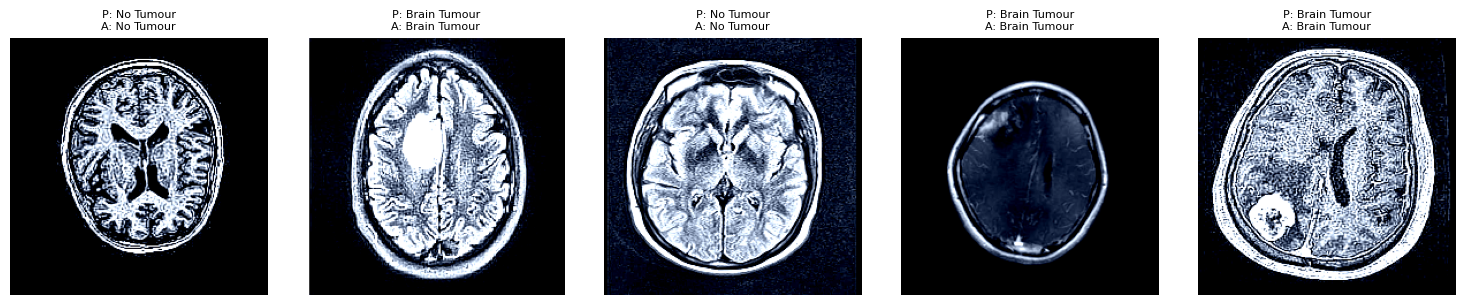

In [22]:
resDensenet_trner.load_model()
resDensenet_trner.predict_random_from_loader(tst_ldr,num_images=5)

# **Hybrid Model 2:DenseNet & EfficientNet**

In [23]:
class denseEfficient(nnx.Module):
    def __init__(self, num_classes=2):
        super(denseEfficient, self).__init__()

        # Load backbones without classifiers (feature extractors only)
        self.densenet = timm.create_model('densenet121', pretrained=True, num_classes=0, global_pool='')
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='')

        # Feature dimensions
        self.densenet_out = self.densenet.num_features
        self.efficientnet_out = self.efficientnet.num_features
        total_features = self.densenet_out + self.efficientnet_out

        # Common global average pooling
        self.global_pool = nnx.AdaptiveAvgPool2d(1)

        # Final classification head
        self.classifier = nnx.Sequential(
            nnx.Flatten(),
            nnx.Linear(total_features, 256),
            nnx.ReLU(),
            nnx.Dropout(0.6),  # Increased dropout for regularization
            nnx.Linear(256, 128),
            nnx.ReLU(),
            nnx.Dropout(0.5),
            nnx.Linear(128, num_classes)
        )

    def forward(self, x):
        d = self.global_pool(self.densenet(x))        # [B, densenet_out, 1, 1]
        e = self.global_pool(self.efficientnet(x))    # [B, efficientnet_out, 1, 1]
        concat = trc.cat([d, e], dim=1)             # [B, total_features, 1, 1]
        return self.classifier(concat)


In [24]:
# Define the DenseNet-EfficientNet Hybrid Model
dense_efficient_model = denseEfficient(num_classes=2).to(dvc)

# Define loss function with label smoothing for stabilization
criterion = nnx.CrossEntropyLoss(label_smoothing=0.1)  # Stabilizes loss function by avoiding sharp predictions

# Define optimizer with weight decay for regularization
optimizer = optimx.Adam(
    dense_efficient_model.parameters(),
    lr=0.0005,  # Lower learning rate for precise updates
    weight_decay=1e-4  # Regularization to prevent overfitting
)

# Learning rate scheduler with patience
scheduler = rlrp(optimizer, mode='min', factor=0.1, patience=3)

# Initialize the trainer with an increased patience for early stopping
dense_efficient_trner = Basetrner(
    model=dense_efficient_model,
    trn_loader=trn_ldr,
    val_loader=val_ldr,
    tst_loader=tst_ldr,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=dvc,
    early_stopping_patience=10,  # Increased patience for smoother convergence
    model_name='Dense_Efficient_Hybrid.pt'
)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch [1/20] train Loss: 0.3631 Acc: 0.9053 | Val Loss: 0.2285 Acc: 0.9860
Epoch [2/20] train Loss: 0.2507 Acc: 0.9840 | Val Loss: 0.2270 Acc: 0.9860
Epoch [3/20] train Loss: 0.2462 Acc: 0.9840 | Val Loss: 0.2122 Acc: 0.9965
Epoch [4/20] train Loss: 0.2244 Acc: 0.9934 | Val Loss: 0.2212 Acc: 0.9930
Epoch [5/20] train Loss: 0.2273 Acc: 0.9918 | Val Loss: 0.2095 Acc: 0.9965
Epoch [6/20] train Loss: 0.2222 Acc: 0.9949 | Val Loss: 0.2166 Acc: 0.9895
Epoch [7/20] train Loss: 0.2246 Acc: 0.9949 | Val Loss: 0.2200 Acc: 0.9895
Epoch [8/20] train Loss: 0.2244 Acc: 0.9930 | Val Loss: 0.2111 Acc: 0.9965
Epoch [9/20] train Loss: 0.2239 Acc: 0.9942 | Val Loss: 0.2154 Acc: 0.9930
Epoch [10/20] train Loss: 0.2124 Acc: 0.9988 | Val Loss: 0.2120 Acc: 0.9930
Epoch [11/20] train Loss: 0.2094 Acc: 0.9996 | Val Loss: 0.2096 Acc: 0.9965
Epoch [12/20] train Loss: 0.2096 Acc: 0.9992 | Val Loss: 0.2136 Acc: 0.9930
Epoch [13/20] train Loss: 0.2087 Acc: 1.0000 | Val Loss: 0.2115 Acc: 0.9930
Epoch [14/20] train L

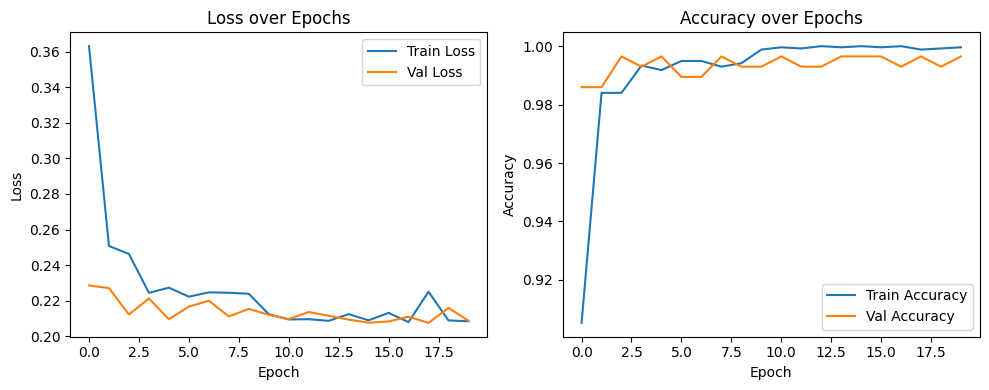

Model saved to /kaggle/working/DenseNet_Eff_Hybrid.pth


In [25]:
# Train the model
num_epochs = 20
dense_efficient_trner.trn(num_epochs)

# Save the final model
dense_efficient_trner.save_model('/kaggle/working/DenseNet_Eff_Hybrid.pth')

Acc : 1.0000
Pr  : 1.0000
Rc  : 1.0000
F1  : 1.0000

Classification Report:
              precision    recall  f1-score   support

   No Tumour     1.0000    1.0000    1.0000      1276
      Tumour     1.0000    1.0000    1.0000      1289

    accuracy                         1.0000      2565
   macro avg     1.0000    1.0000    1.0000      2565
weighted avg     1.0000    1.0000    1.0000      2565



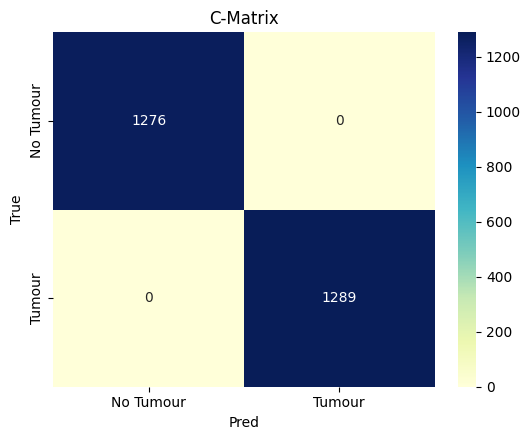

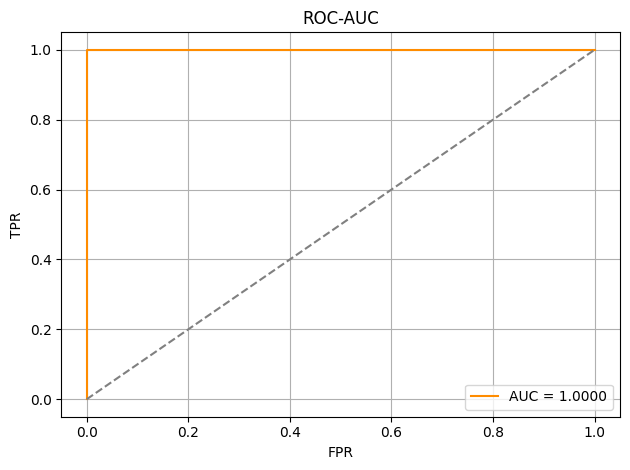

In [26]:
## Training resutl 
DenseNet_EfficientNet_Trn_Res=dense_efficient_trner.print_metrics(trn_ldr)

Acc : 0.9933
Pr  : 0.9929
Rc  : 0.9938
F1  : 0.9933

Classification Report:
              precision    recall  f1-score   support

   No Tumour     0.9857    1.0000    0.9928        69
      Tumour     1.0000    0.9877    0.9938        81

    accuracy                         0.9933       150
   macro avg     0.9929    0.9938    0.9933       150
weighted avg     0.9934    0.9933    0.9933       150



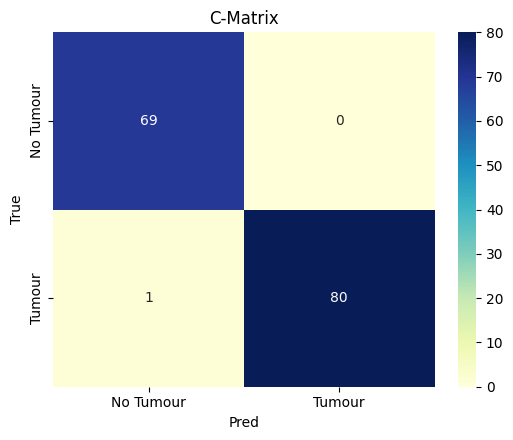

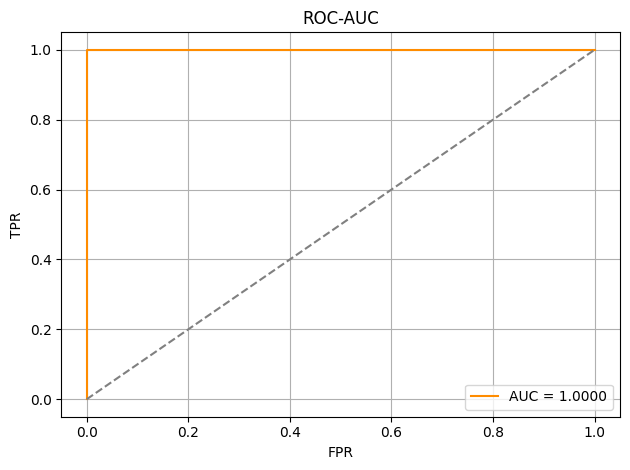

In [27]:
DenseNet_EfficientNet_tst_Res=dense_efficient_trner.print_metrics(tst_ldr)

Model loaded from Dense_Efficient_Hybrid.pt


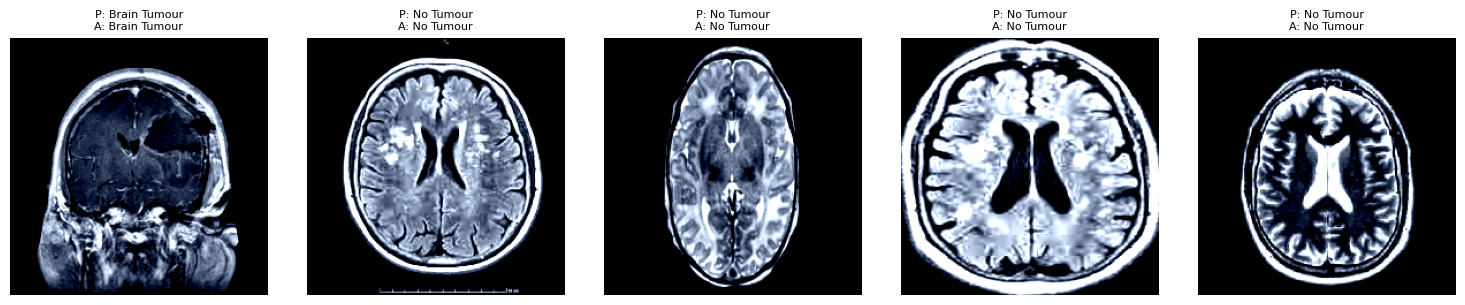

In [28]:
dense_efficient_trner.load_model()
dense_efficient_trner.predict_random_from_loader(tst_ldr,num_images=5)

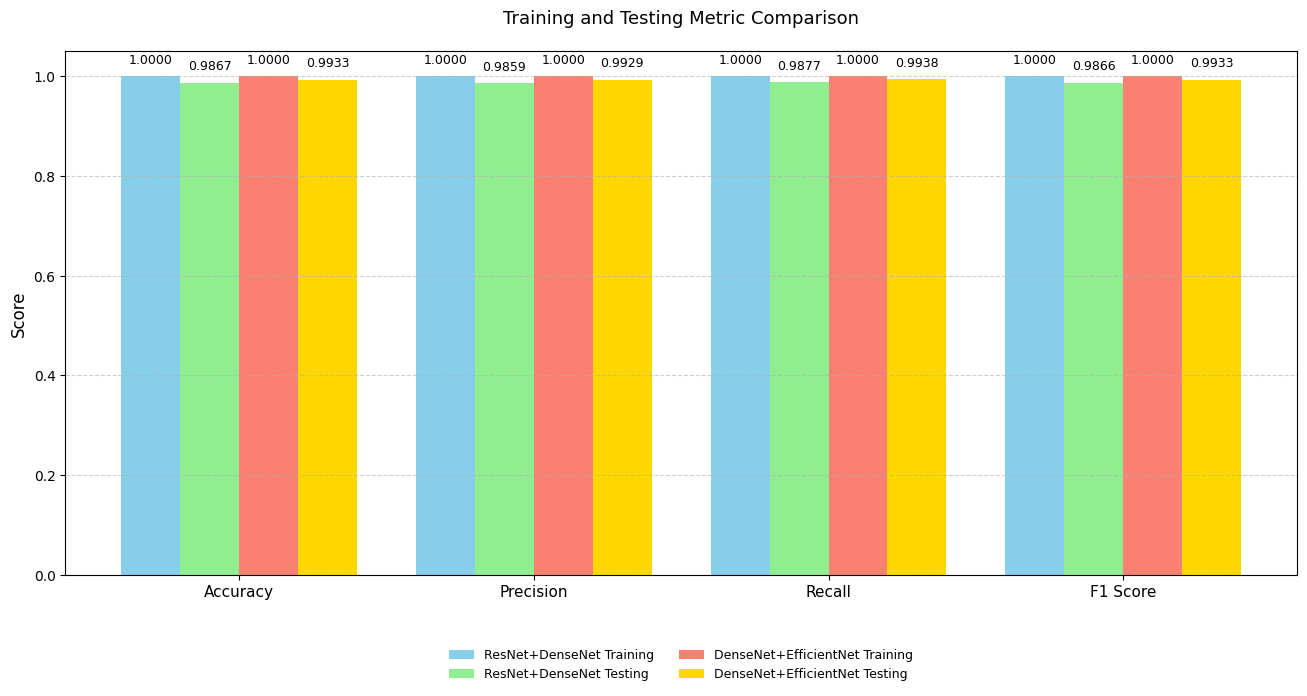

In [41]:
# Extract metrics for training and testing results
metrics_train_1 = ResNet_DenseNet_Train_Result
metrics_test_1 = ResNet_DenseNet_Test_Result
metrics_train_2 = DenseNet_EfficientNet_Trn_Res
metrics_test_2 = DenseNet_EfficientNet_tst_Res

# Extract metric names and corresponding values for each dataset
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

values_train_1 = [metrics_train_1['A'], metrics_train_1['P'], metrics_train_1['R'], metrics_train_1['F']]
values_test_1 = [metrics_test_1['A'], metrics_test_1['P'], metrics_test_1['R'], metrics_test_1['F']]
values_train_2 = [metrics_train_2['A'], metrics_train_2['P'], metrics_train_2['R'], metrics_train_2['F']]
values_test_2 = [metrics_test_2['A'], metrics_test_2['P'], metrics_test_2['R'], metrics_test_2['F']]

# Set up bar width and positions
x = range(len(labels))
bar_w = 0.2  # Adjusted bar width for four groups

# Create bar plot
pltx.figure(figsize=(12, 6))  # Increased figure size
bars_train_1 = pltx.bar([i - 1.5 * bar_w for i in x], values_train_1, width=bar_w,
                        label='ResNet+DenseNet Training', color='skyblue')
bars_test_1 = pltx.bar([i - 0.5 * bar_w for i in x], values_test_1, width=bar_w,
                       label='ResNet+DenseNet Testing', color='lightgreen')
bars_train_2 = pltx.bar([i + 0.5 * bar_w for i in x], values_train_2, width=bar_w,
                        label='DenseNet+EfficientNet Training', color='salmon')
bars_test_2 = pltx.bar([i + 1.5 * bar_w for i in x], values_test_2, width=bar_w,
                       label='DenseNet+EfficientNet Testing', color='gold')

# Add value labels above bars
for i in range(len(labels)):
    pltx.text(bars_train_1[i].get_x() + bars_train_1[i].get_width() / 2, bars_train_1[i].get_height() + 0.02,
              f"{values_train_1[i]:.4f}", ha='center', va='bottom', fontsize=9)
    pltx.text(bars_test_1[i].get_x() + bars_test_1[i].get_width() / 2, bars_test_1[i].get_height() + 0.02,
              f"{values_test_1[i]:.4f}", ha='center', va='bottom', fontsize=9)
    pltx.text(bars_train_2[i].get_x() + bars_train_2[i].get_width() / 2, bars_train_2[i].get_height() + 0.02,
              f"{values_train_2[i]:.4f}", ha='center', va='bottom', fontsize=9)
    pltx.text(bars_test_2[i].get_x() + bars_test_2[i].get_width() / 2, bars_test_2[i].get_height() + 0.02,
              f"{values_test_2[i]:.4f}", ha='center', va='bottom', fontsize=9)

# Formatting
pltx.xticks(x, labels, fontsize=11)
pltx.ylim(0, 1.05)
pltx.ylabel('Score', fontsize=12)
pltx.title('Training and Testing Metric Comparison', fontsize=13, pad=20)

# Smaller legend with adjusted position
pltx.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

pltx.grid(axis='y', linestyle='--', alpha=0.6)
pltx.tight_layout(pad=-4.0, rect=[0.02, 0.02, 1, 0.95])  # Increased padding
pltx.show()
